Image to text using salesforce blip

source: https://huggingface.co/Salesforce/blip-image-captioning-large

Need ```PIL``` and ```transformers```, which requieres ```pytorch``` and ```tensorflow```

In [1]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")


# Sample usage---------------------------------------------------------
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\transformers\generation\utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a woman and her dog on the beach


C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\transformers\generation\utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


woman sitting on the beach with her dog and a cell phone


### Read the jpg files

In [2]:
import os
import glob

# Replace this with the directory you want to search in
directory = '../1_download_data/data/raw/'


def get_jpg_files(folder_path):
    jpg_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                jpg_files.append(os.path.join(root, file))
    return jpg_files

# Example usage
folder_path = '../1_download_data/data/raw/'
jpg_files = get_jpg_files(folder_path)
jpg_files[0:10]

['../1_download_data/data/raw/-PHbiexlr_\\2015-11-18_18-26-59_UTC.jpg',
 '../1_download_data/data/raw/3YO1o0Rlkt\\2015-06-01_07-45-08_UTC.jpg',
 '../1_download_data/data/raw/4yqgDyxloK\\2015-07-06_10-38-30_UTC.jpg',
 '../1_download_data/data/raw/B-y2Fo8qcN_\\2020-04-10_08-57-20_UTC.jpg',
 '../1_download_data/data/raw/B3__d73i46x\\2019-10-24_11-49-40_UTC.jpg',
 '../1_download_data/data/raw/B8zBgZeD8bQ\\2020-02-20_17-34-19_UTC.jpg',
 '../1_download_data/data/raw/B9UltWvIDjA\\2020-03-04_18-25-36_UTC.jpg',
 '../1_download_data/data/raw/B9XY-IjjDWt\\2020-03-05_20-32-01_UTC_1.jpg',
 '../1_download_data/data/raw/B9XY-IjjDWt\\2020-03-05_20-32-01_UTC_2.jpg',
 '../1_download_data/data/raw/BBIHpekRlhD\\2016-01-29_14-48-24_UTC.jpg']

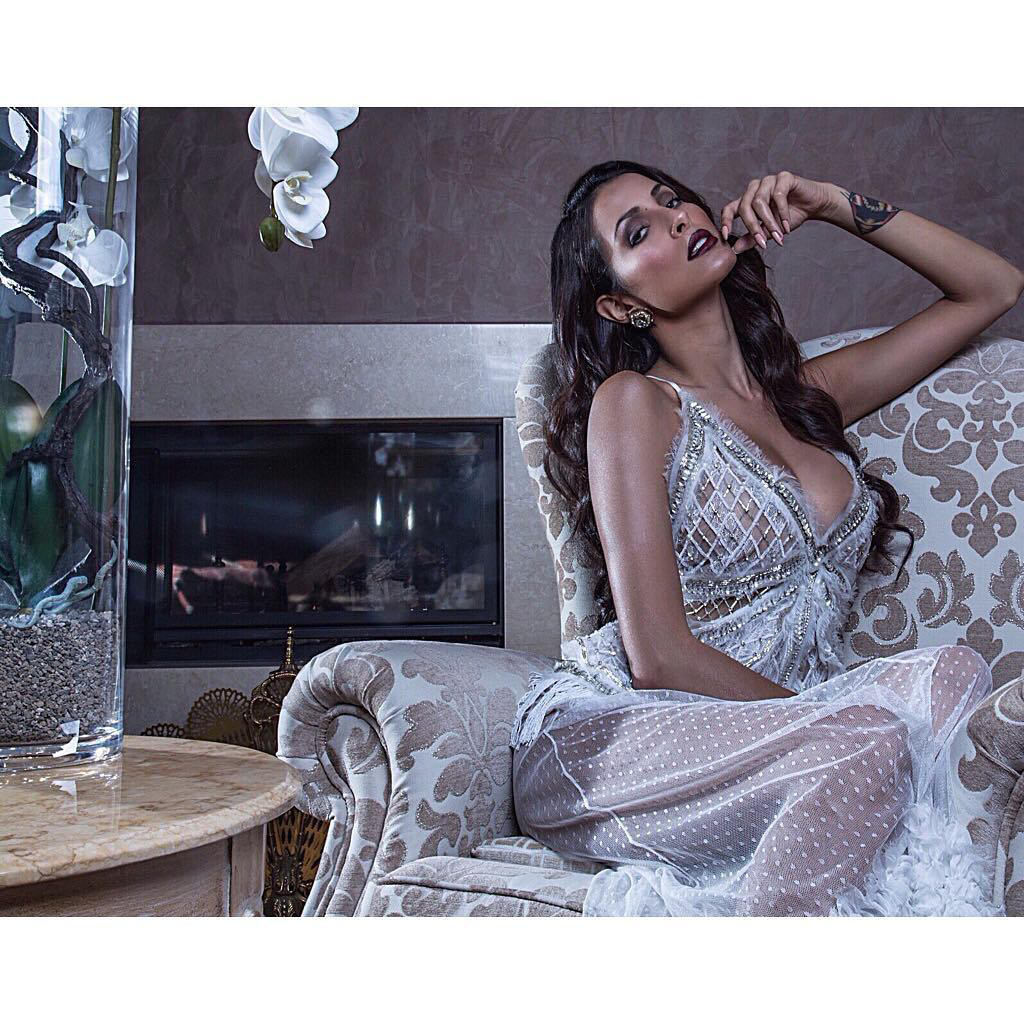

In [3]:
# Check if images can be opened
from PIL import Image
# Replace 'path_to_image.jpg' with the path to your local image file
image_path = jpg_files[0]
raw_image = Image.open(image_path).convert('RGB')
raw_image

### Blip tuned for captioning
https://huggingface.co/noamrot/FuseCap_Image_Captioning

In [4]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = BlipProcessor.from_pretrained("noamrot/FuseCap")
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap").to(device)

image_path = jpg_files[0]
raw_image = Image.open(image_path).convert('RGB')
raw_image

text = "a picture of "
inputs = processor(raw_image, text, return_tensors="pt").to(device)

out = model.generate(**inputs, num_beams = 3)
print(processor.decode(out[0], skip_special_tokens=True))

a picture of a woman with long black hair sits on a couch in front of a black fireplace, wearing a white dress and holding a white flower in her hand a round wooden table is visible


# Caption Images
Use the transformer model to caption each image and store the captions in a dictionary

In [5]:
from PIL import Image, ImageFile
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading of truncated images
dict_captions = {}
for image in tqdm(jpg_files):
    short_name = image.split('\\')[1]
    try:
        with Image.open(image) as img:
            raw_image = img.convert('RGB')
            # Further processing of raw_image if needed
            # unconditional image captioning
            text = "a picture of "
            inputs = processor(raw_image, text, return_tensors="pt").to(device)
            out = model.generate(**inputs, num_beams = 3)
            dict_captions[short_name] = processor.decode(out[0], skip_special_tokens=True)
    except IOError as e:
        print(f"Cannot process image {image}: {e}")
        dict_captions[short_name] = ''

100%|██████████████████████████████████████████████████████████████████████████████| 764/764 [2:21:53<00:00, 11.14s/it]


In [6]:
dict_captions['2015-11-18_18-26-59_UTC.jpg']

'a picture of a woman with long black hair sits on a couch in front of a black fireplace, wearing a white dress and holding a white flower in her hand a round wooden table is visible'

In [8]:
import pandas as pd

#og_directory = '../'
# Change directory
#os.chdir(og_directory)

df_captions =  pd.DataFrame(list(dict_captions.items()), columns=['Long', 'Auto_caption'])
df_captions.to_excel('../0_data/autogen_captions.xlsx', index=False)